This is the setup cell

In [1]:
import datetime
import pathlib
import time
import math

import obspy
from obspy.signal import PPSD
import scipy
import matplotlib.pyplot as plt

#Run this line if you want interactive plots
%matplotlib qt

import numpy as np

import sprit

In [2]:
#sprit.gui()

In [3]:
dPath = r'\\isgs-sinkhole.ad.uillinois.edu\geophysics\HVSR\LakeCalumet\LC_RaspShake'
#dPath = r'\\isgs-sinkhole.ad.uillinois.edu\geophysics\HVSR\LakeCalumet\LC_RaspShake\Test12_AM.RAC84.00.2023-02-15_2132-2200.mseed'
trimDir = r'\\isgs-sinkhole.ad.uillinois.edu\geophysics\HVSR\LakeCalumet\LC_RaspShake'
#dPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\HVSR\ChampaignCo\Mahomet2023\Data\RawData"
#dPath = r"C:\Users\riley\OneDrive - University of Illinois - Urbana\Data_OneDrive\Seismic\HVSR\Data\RAC84"
dPath = r"C:\Users\riley\OneDrive - University of Illinois - Urbana\Data_OneDrive\Seismic\HVSR\Data\UOFI1_AM.RAC84.00.2023-02-15_1704-1734.mseed"
#dPath = r"\\isgs-sinkhole.ad.uillinois.edu\geophysics\HVSR\LakeCalumet\LC_RaspShake\Test_AM.RAC84.00.2023-02-15_2132-2200.mseed"

params = sprit.input_params( acq_date='2023-02-15',
                            #starttime = obspy.UTCDateTime('2023-02-06T21:32:00.00'),
                            #endtime = obspy.UTCDateTime('2023-02-06T22:00:00.00'),
                            tzone = 'UTC',#or 'local', #or 'UTC'
                            dst=False,
                            lon = -88.2290526,
                            lat =  40.1012122,
                            elevation = 755,
                            site = 'HVSR Site',
                            dataPath = dPath
                            )

No metadata file specified!
Using default metadata file for Raspberry Shake v.7 contained in repository at
 c:/Users/riley/LocalData/Github/SPRIT/resources/raspshake_metadata.inv


In [4]:
params = sprit.get_metadata(params)
params = sprit.fetch_data(params=params, source='file')

c:\Users\riley\LocalData\virtual_envs\seismic310_venv\lib\site-packages\obspy\core\inventory\network.py:251: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)


In [5]:
params = sprit.select_windows(params)
params = sprit.remove_noise(params, kind='saturation', sat_percent=0.7, min_win_size=0)
sprit.show_removed_windows(params, fig=params['fig'], ax=params['ax'])

[    9  2769  2818 72816 72819 72831 72835 72836 72847 72884]
(132152,)
(132142,)
no windows 10
<class 'dict'>


(<Figure size 640x480 with 4 Axes>,
 {'spec': <Axes: label='spec', ylabel="Spectrogram: ['Z']">,
  'signalz': <Axes: label='signalz', ylabel='Z'>,
  'signaln': <Axes: label='signaln', ylabel='N'>,
  'signale': <Axes: label='signale', xlabel='UTC Time \n2023-2-15', ylabel='E'>})

In [41]:
#Helper function for removing gaps
def __remove_gaps(stream, window_gaps_obspy):
    """Helper function for removing gaps
    stream : obspy.Stream
        Obspy stream with 3 traces
    window_gaps_obspy : list
        List of two-item lists as such: [[stream_start, stream_start], [gap1_start, gap1_end],[gap2_start, gap2_end], ..., [stream_end, stream_end]]
        Note that the list is buffered on the start and end with the start and end times of the stream itself
    
    """

    #combine overlapping windows
    #Not sure if this part works yet
    overlapList = []
    for i in range(len(window_gaps_obspy)-2):
        if window_gaps_obspy[i][1] > window_gaps_obspy[i+1][0]:
            overlapList.append(i)

    for i in overlapList:
        if i < len(window_gaps_obspy)-2:
            window_gaps_obspy[i][1] = window_gaps_obspy[i+1][1]
            window_gaps_obspy.pop(i+1)

    #Add streams
    window_gaps_s = []
    for w, win in enumerate(window_gaps_obspy):
        if w == 0:
            pass
        elif w == len(window_gaps_obspy)-1:
            pass
        else:
            window_gaps_s.append(win[1]-win[0])

    if len(window_gaps_s) > 0:
        stream_windows = []
        j = 0
        for i, window in enumerate(window_gaps_s):
            j=i
            newSt = stream.copy()
            stream_windows.append(newSt.trim(starttime=window_gaps_obspy[i][1], endtime=window_gaps_obspy[i+1][0]))
        i = j + 1
        newSt = stream.copy()
        stream_windows.append(newSt.trim(starttime=window_gaps_obspy[i][1], endtime=window_gaps_obspy[i+1][0]))

        for i, st in enumerate(stream_windows):
            if i == 0:
                outStream = st.copy()
            else:
                newSt = st.copy()
                gap = window_gaps_s[i-1]
                outStream = outStream + newSt.trim(starttime=st[0].stats.starttime - gap, pad=True, fill_value=None)       
        outStream.merge()
    else:
        outStream = stream.copy()

    return outStream

#Remove noise saturation
def __remove_noise_saturate(stream, sat_percent, min_win_size):
    if sat_percent > 1:
        sat_percent = sat_percent / 100

    removeInd = np.array([], dtype=int)
    for trace in stream:
        dataArr = trace.data.copy()

        sample_rate = trace.stats.delta

        #Get max amplitude value
        maxAmp = np.max(np.absolute(dataArr, where = not None))
        thresholdAmp = maxAmp * sat_percent
        cond = np.nonzero(np.absolute(dataArr, where=not None) > thresholdAmp)[0]
        removeInd = np.hstack([removeInd, cond])
        #trace.data = np.ma.where(np.absolute(data, where = not None) > (noise_percent * maxAmp), None, data)
    #Combine indices from all three traces
    removeInd = np.unique(removeInd)
    
    removeList = []  # initialize
    min_win_samples = int(min_win_size / sample_rate)

    if len(removeInd) > 0:
        startInd = removeInd[0]
        endInd = removeInd[0]

        for i in range(0, len(removeInd)):             
            if removeInd[i] - removeInd[i-1] > 1:
                startInd = removeInd[i]
            endInd = removeInd[i]

            if endInd - startInd >= min_win_samples:
                removeList.append([int(startInd), int(endInd)])

    removeList.append([-1, -1]) #figure out a way to get rid of this
    #print(removeList)

    #Convert removeList from samples to seconds after start to UTCDateTime
    sampleRate = stream[0].stats.delta
    startT = stream[0].stats.starttime
    endT = stream[0].stats.endtime
    removeSec = []
    removeUTC = []
    for i, win in enumerate(removeList):
        removeSec.append(list(np.round(sampleRate * np.array(win),6)))
        removeUTC.append(list(np.add(startT, removeSec[i])))
    removeUTC[-1][0] = removeUTC[-1][1] = endT
    
    outstream  = __remove_gaps(stream, removeUTC)

    return outstream

__remove_noise_saturate(stream=params['stream'], sat_percent=0.95, min_win_size=0)

3 Trace(s) in Stream:
AM.RAC84.00.EHE | 2023-02-15T17:11:58.590000Z - 2023-02-15T17:34:00.000000Z | 100.0 Hz, 132142 samples
AM.RAC84.00.EHN | 2023-02-15T17:11:58.590000Z - 2023-02-15T17:34:00.000000Z | 100.0 Hz, 132142 samples
AM.RAC84.00.EHZ | 2023-02-15T17:11:58.590000Z - 2023-02-15T17:34:00.000000Z | 100.0 Hz, 132142 samples

In [5]:
params=sprit.remove_noise(input=params, kind='noise', lta=30, min_win_size=1, noise_percent=0.5)

0


In [8]:
sprit.show_removed_windows(input=params,time_type='samples')

(0.0, 175794.0)

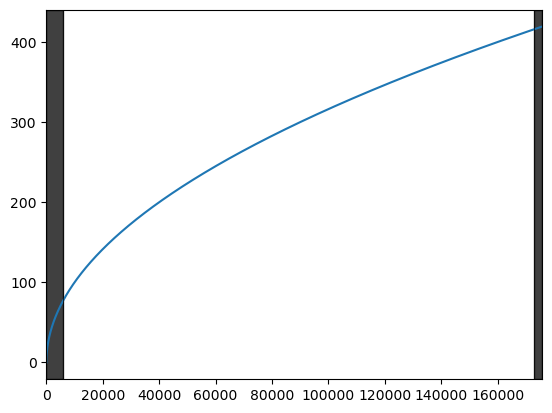

In [17]:
fig, ax = plt.subplots(nrows=1, sharex=True)
x = np.arange(params['stream'][0].stats.npts)
y = x**0.5
ax.plot(x, y)

sprit.show_removed_windows(input=params, fig=fig, ax=ax, time_type='samples')
ax.set_xlim([0, params['stream'][0].stats.npts])

In [59]:
testTrace = params['stream'][0].copy()
windows = []
windows.append([0,np.nan])

lastMaskInd = -1
wInd = 0
masked_array = testTrace.data.mask.nonzero()[0]
for i, maskInd in enumerate(masked_array):
    if maskInd-lastMaskInd != 1:
        windows.append([np.nan, np.nan])
        windows[wInd][1] = masked_array[i - 1]
        wInd += 1
        windows[wInd][0] = masked_array[i]

    lastMaskInd = maskInd    
windows[wInd][1] = masked_array[-1]

In [13]:
print(float(params['stream'][0].stats.endtime - params['stream'][0].stats.starttime) / params['stream'][0].stats.delta)
print(params['stream'][0].stats.npts)

175793.0
175794


In [ ]:
params = sprit.remove_noise(input=params, kind='auto')

c:\ProgramData\Anaconda3\envs\seismic39\lib\site-packages\obspy\signal\trigger.py:183: UserWarning: Warning: converting a masked element to nan.
  data = np.ascontiguousarray(data, dtype=np.float64)


In [9]:
params = sprit.generate_ppsds(params=params, stream=params['stream'], ppsd_length=60, 
                              overlap=0.5, period_step_octaves=0.01, remove_outliers=True, outlier_std=1.5)

In [10]:
hvsr_dict = sprit.process_hvsr(params=params, method=4, resample=True, smooth=3, remove_outlier_curves=True)
hvsr_dict = sprit.check_peaks(hvsr_dict=hvsr_dict)

In [9]:
sprit.hvplot(hvsr_dict, kind='hvsr p tp ann', cmap='turbo')

In [15]:
hvsr_dict['Best Peak']['Report']

{'Lw': '2.846 > 10 / 60  ✔',
 'Nc': '8878.0 > 200  ✔',
 'σ_A(f)': 'σ_A for all freqs 1.423-5.691 < 2  ✔',
 'A(f-)': 'A(0.716): 1.812 < 3.68  ✔',
 'A(f+)': 'A(11.311): 1.69 < 3.68  ✔',
 'A0': '      7.36 > 2.0 ✔',
 'P+': '2.863 within ±5% of 2.846 ✔',
 'P-': '2.846 within ±5% of 2.846 ✔',
 'Sf': '    0.1259 < 0.05 * 2.846 ✔',
 'Sa': '    0.0229 < 0.20 ✔'}

In [14]:
hvsr_dict['Best Peak']['Pass List']


{'Window Length Freq.': True,
 'Significant Cycles': True,
 'Low Curve StDev. over time': True,
 'Peak Freq. Clarity Below': True,
 'Peak Freq. Clarity Above': True,
 'Peak Amp. Clarity': True,
 'Freq. Stability': True,
 'Peak Stability (freq. std)': True,
 'Peak Stability (amp. std)': True}

In [10]:
outDF = sprit.print_report(hvsr_dict, export='', format='csv', include='peak', save_figs=None)
outDF

\\isgs-sinkhole.ad.uillinois.edu\geophysics\HVSR\LakeCalumet\LC_RaspShake\Test_AM.RAC84.00.2023-02-15_2132-2200.csv


,Site Name,Acqusition Date,Longitude,Latitide,Elevation,Peak Frequency,Window Length Freq.,Significant Cycles,Low Curve StDev. over time,Peak Freq. Clarity Below,Peak Freq. Clarity Above,Peak Amp. Clarity,Freq. Stability,Peak Stability (freq. std),Peak Stability (amp. std),Peak Passes
0,HVSR Site,2023-02-15,-88.229053,40.101212,755,2.863,True,True,True,True,True,True,True,False,True,True
